# **I. Introduction**


Nama : Monica M. Pratiwi
<br>
Batch : FTDS-016-RMT


## **Dataset yang Digunakan**

Pada tugas kali ini, dataset yang digunakan tidak akan menggunakan bigquery-public-data. Cara memperoleh data yang digunakan adalah dengan cara sebagai berikut:
1. Masuk ke dalam Google BigQuery.
2. Gunakan informasi dibawah ini sebagai tempat untuk mengambil data (gunakan sebagai informasi untuk klausa FROM)
* Project ID : ftds-hacktiv8-project
* Dataset Name : phase1_ftds_016_rmt
* Table Name : credit-card-information
* Ambil semua data dengan column CUST_ID bernilai genap.

In [1]:
# Query yang digunakan
# select*from `ftds-hacktiv8-project.phase1_ftds_016_rmt.credit-card-information` 
# where MOD(CUST_ID, 2) = 0 ORDER BY CUST_ID;

## **Objective**

Membuat model clustering untuk melakukan Customer Segmentation dari data kartu kredit sebuah bank.

# **II. Import Libraries**

In [153]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from numpy import array 
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from ast import Assign
from sklearn.mixture import GaussianMixture 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import joblib
import json
import warnings
warnings.filterwarnings("ignore")

# **III. Data Loading**

Data yang sudah dipilih kemudian disimpan dengan nama `h8dsft_P1G4_monica_pratiwi` dalam format .csv di Google Drive. Selanjutnya, dibuat dataframe menggunakan data tersebut dengan nama `data`. 

In [3]:
# Loading Dataset

data = pd.read_csv('/content/drive/MyDrive/bq-results-20221121-072603-1669016735963/h8dsft_P1G4_monica_pratiwi.csv')
data

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,2,4613.570499,1.000000,0.00,0.00,0.00,1728.341939,0.000000,0.000000,0.000000,0.090909,1,0,6000.0,922.218961,1460.635220,0.00,11
1,4,2583.247881,1.000000,1337.35,45.65,1291.70,2484.594650,1.000000,0.083333,1.000000,0.500000,18,21,3000.0,819.792196,6404.855484,0.00,12
2,6,1597.911395,1.000000,0.00,0.00,0.00,162.919727,0.000000,0.000000,0.000000,0.250000,3,0,1800.0,548.420841,416.956325,0.00,12
3,8,3506.489102,1.000000,0.00,0.00,0.00,4467.382055,0.000000,0.000000,0.000000,1.000000,11,0,5000.0,286.708354,628.484562,0.00,6
4,10,2306.310095,1.000000,359.96,0.00,359.96,2843.482435,0.916667,0.000000,0.916667,0.333333,6,11,4000.0,1482.816136,2056.434829,0.00,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,8942,83.477053,0.181818,0.00,0.00,0.00,2654.856157,0.000000,0.000000,0.000000,0.083333,2,0,3000.0,12902.188130,1791.729021,0.50,12
4471,8944,8.404256,0.857143,0.00,0.00,0.00,132.266653,0.000000,0.000000,0.000000,0.285714,3,0,2500.0,206.851966,24.421074,0.25,7
4472,8946,4211.539631,1.000000,0.00,0.00,0.00,455.581546,0.000000,0.000000,0.000000,0.083333,1,0,10500.0,1288.287239,1164.178674,0.00,12
4473,8948,111.539712,1.000000,1364.86,0.00,1364.86,0.000000,0.916667,0.000000,0.833333,0.000000,0,11,4000.0,1500.447193,150.868096,0.20,12


Setelah dilakukan loading dataset dari Big Query yang telah disimpan di Google Drive, data disalin agar memiliki cadangan. Selanjutnya, dilakukan pengecekan sederhana kolom-kolom yang ada pada dataset. Berikut keterangan dari kolom-kolom pada tabel.

Header | Notes
---|---
`CUST_ID` | Identification of credit card holder.
`BALANCE` | Balance amount left in their account to make purchases.
`BALANCE_FREQUENCY` | How frequently the balance is updated, score between 0 and 1 (1 = Frequently updated, 0 = Not Frequently updated).
`PURCHASES` | Amount of purchases made from account.
`ONEOFF_PURCHASES` | Maximum purchases amount done in one go.
`INSTALLMENT_PURCHASES` | Amount of purchases done in installment.
`CASH_ADVANCE` | Cash in advance given by the user.
`PURCHASES_FREQUENCY` | How frequently the purchases are being made, score between 0 and 1 (1 = Frequently updated, 0 = Not Frequently updated).
`ONEOFF_PURCHASES_FREQUENCY` | How frequently purchases are happening in one go, score between 0 and 1 (1 = Frequently updated, 0 = Not Frequently updated).
`PURCHASES_INSTALLMENT_FREQUENCY` | How frequently purchases in installments are being done, score between 0 and 1 (1 = Frequently updated, 0 = Not Frequently updated).
`CASH_ADVANCE_FREQUENCY` | How frequently the cash in advance being paid
`CASH_ADVANCE_TRX` | Number of transactions made with 'Cash in Advanced'
`PURCHASES_TRX` | Number of purchase transactions made
`CREDIT_LIMIT` | Limit credit card for user
`PAYMENTS` | Amount of payment done by user
`MINIMUM_PAYMENTS` | 
`PRC_FULL_PAYMENT` |
`TENURE` | 
<br>

In [4]:
# Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

In [5]:
# Data Information
data.describe()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4474.000000,4475.000000,4317.000000,4475.000000,4475.000000
mean,4476.000000,1565.743939,0.877608,1003.158324,588.504849,415.025075,973.453671,0.490122,0.202614,0.364989,0.134156,3.196425,14.490503,4494.020175,1726.212274,854.429538,0.157206,11.516425
std,2583.931114,2091.205727,0.235604,2210.812899,1666.500287,927.360842,2133.464502,0.399874,0.298502,0.397336,0.199221,6.500169,24.156038,3668.535689,2961.258570,2306.411178,0.295869,1.347819
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,0.037744,0.000000,6.000000
25%,2239.000000,132.536353,0.888889,40.065000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,390.206371,169.814310,0.000000,12.000000
50%,4476.000000,874.905296,1.000000,362.480000,29.990000,89.450000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,831.048408,309.854995,0.000000,12.000000
75%,6713.000000,2058.519163,1.000000,1122.640000,580.320000,484.255000,1098.569962,0.916667,0.333333,0.750000,0.181818,4.000000,17.000000,6000.000000,1895.959003,830.395060,0.166667,12.000000
max,8950.000000,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,29282.109150,1.000000,1.000000,1.000000,1.166667,110.000000,358.000000,30000.000000,46930.598240,61031.618600,1.000000,12.000000


In [6]:
# Make a copy of data
data_2=data.copy()

In [7]:
data.iloc[:, 7:11]

,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY
0,0.000000,0.000000,0.000000,0.090909
1,1.000000,0.083333,1.000000,0.500000
2,0.000000,0.000000,0.000000,0.250000
3,0.000000,0.000000,0.000000,1.000000
4,0.916667,0.000000,0.916667,0.333333
...,...,...,...,...
4470,0.000000,0.000000,0.000000,0.083333
4471,0.000000,0.000000,0.000000,0.285714
4472,0.000000,0.000000,0.000000,0.083333
4473,0.916667,0.000000,0.833333,0.000000


# **IV. Exploratory Data Analysis (EDA)**

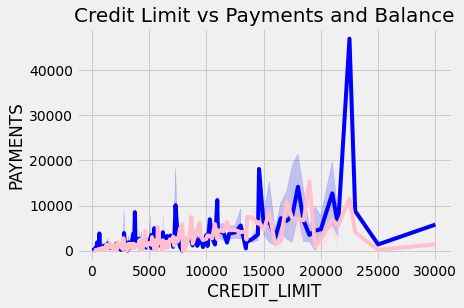

In [8]:
# Credit Limit vs Payments and Balance

x = data['CREDIT_LIMIT']
y = data['PAYMENTS']
z = data['BALANCE']

sns.lineplot(x, y, color = 'blue')
sns.lineplot(x, z, color = 'pink')
plt.title('Credit Limit vs Payments and Balance', fontsize = 20)
plt.show()

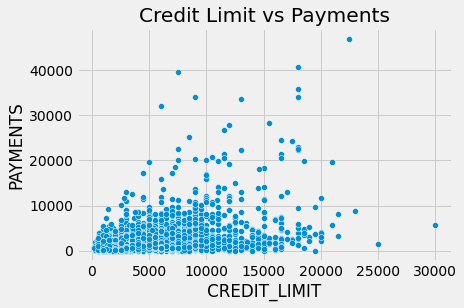

In [9]:
# Make Scatterplot
sns.scatterplot(data=data, x="CREDIT_LIMIT", y="PAYMENTS")
plt.title('Credit Limit vs Payments')
plt.show()

Sebagian besar customer memiliki kredit limit antara 0 hingga 15000 dan melakukan pembayaran yang sesuai dengan credit limitnya. Ada beberapa customer yang memiliki credit limit cukup besar dan nilai pembayaran yang kecil yang dapat mengindikasikan customer tersebut tidak menggunakan kartu kredit sebagai alat pembayaran utama mereka.

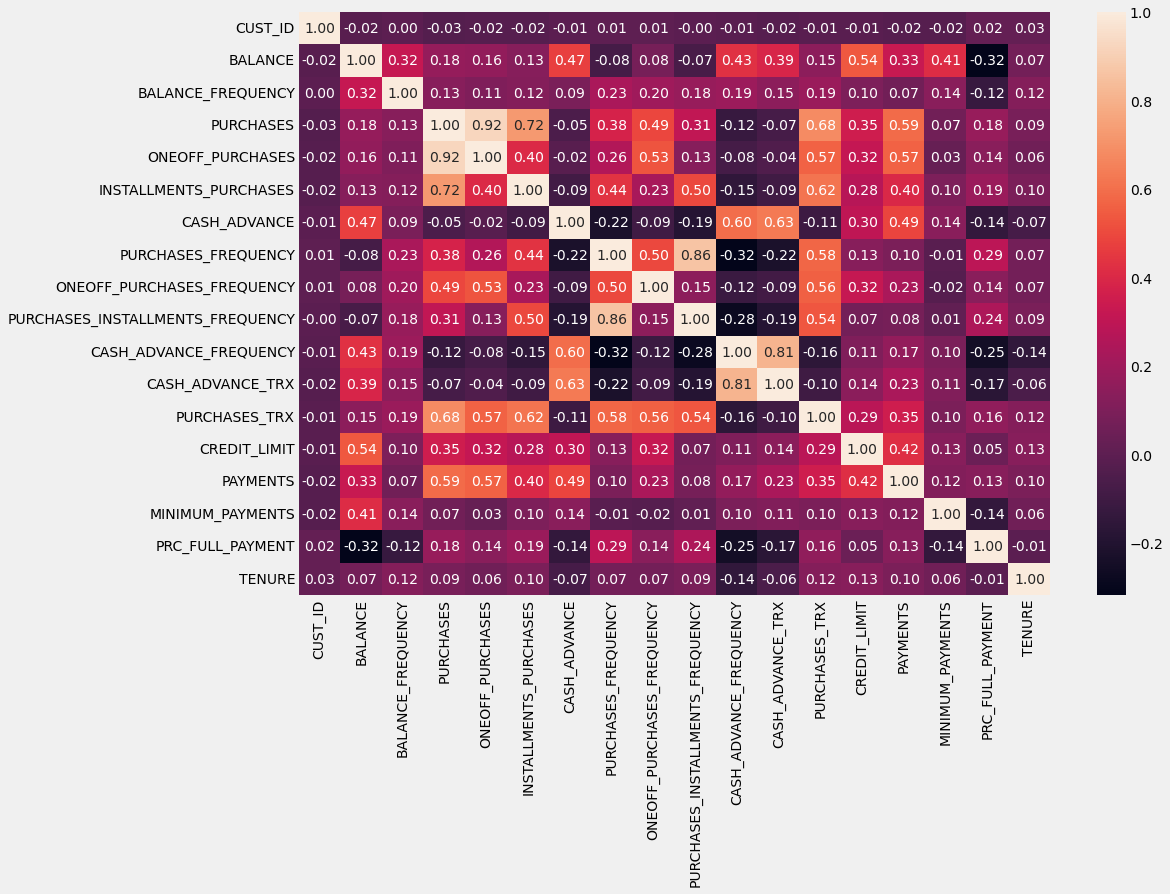

CPU times: user 2.68 s, sys: 246 ms, total: 2.93 s
Wall time: 3.72 s


In [10]:
%%time
# Heatmap Correlation Matrix

plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.show()

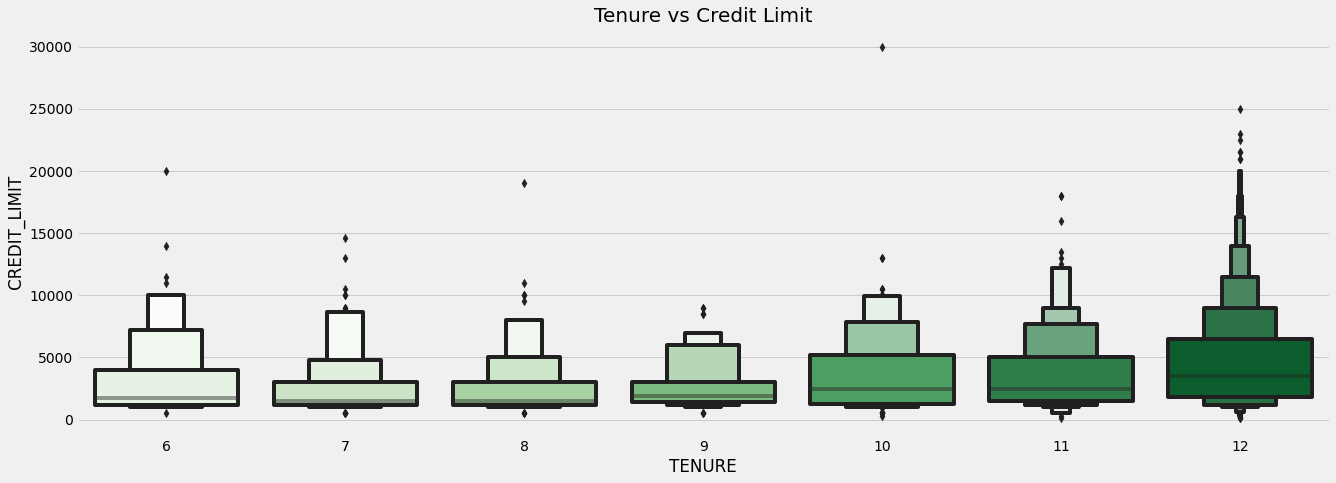

In [11]:
#  Tenure vs Credit Limit

plt.rcParams['figure.figsize'] = (20, 7)
sns.boxenplot(data['TENURE'], data['CREDIT_LIMIT'], palette = 'Greens')
plt.title('Tenure vs Credit Limit', fontsize = 20)
plt.show()

Sebagian besar customer memiliki tenure 12 dengan credit limit tertinggi mencapai 25000. Namun nilai tersebut bukanlah nilai credit limit terbesar karena nilai terbesarnya berada di customer dengan tenure 10.

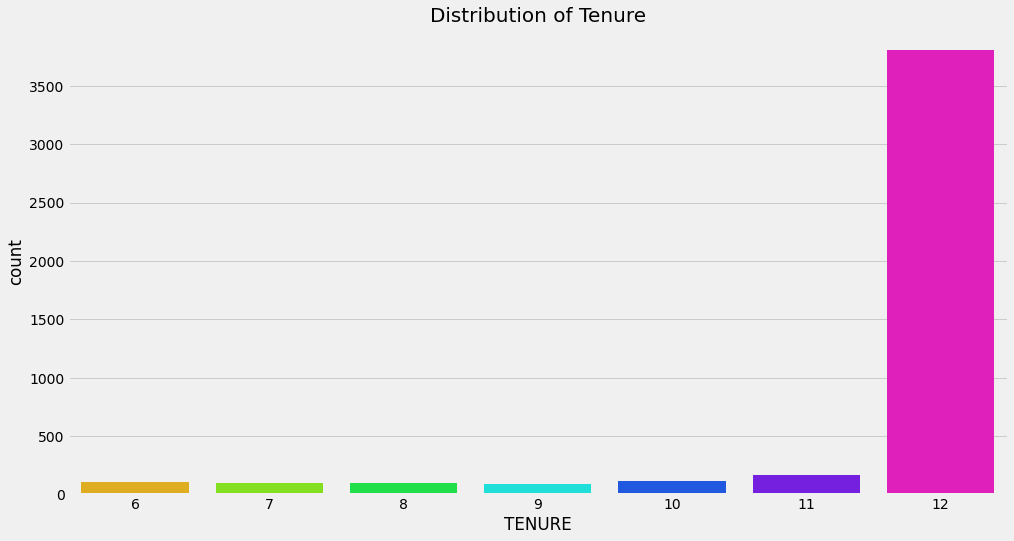

In [12]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.countplot(data['TENURE'], palette = 'hsv')
plt.title('Distribution of Tenure', fontsize = 20)
plt.show()

# **V. Data Preprocessing**

## **Get data for Model Inference, Define Features, Splitting between Train-Set & Test-Set**

In [13]:
# Get data for model inference

data_inference = data.sample(15, random_state=1993)

In [14]:
# Remove inference set from dataset

data_train_test = data.drop(data_inference.index)

In [15]:
# Reset Index

data_train_test.reset_index(drop=True, inplace=True)
data_inference.reset_index(drop=True, inplace=True)

In [77]:
# Define Features `X ` and Splitting between Train-Set & Test-Set

X = data_train_test

## **Outlier Handling**

In [78]:
# Get columns name
X.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

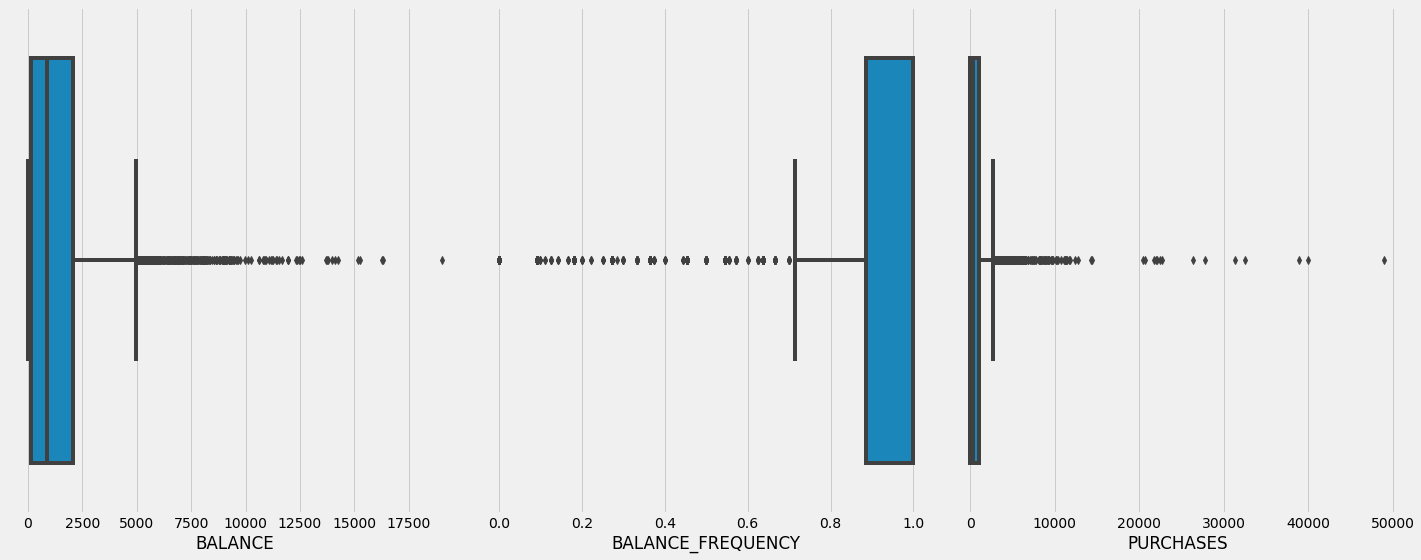

In [79]:
# distribution plots for 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES'

plt.figure(figsize = (20, 8))
plotnumber = 1

for col in (['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES']):
    if plotnumber <= 3:
        ax = plt.subplot(1, 3, plotnumber)
        sns.boxplot(X[col])
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

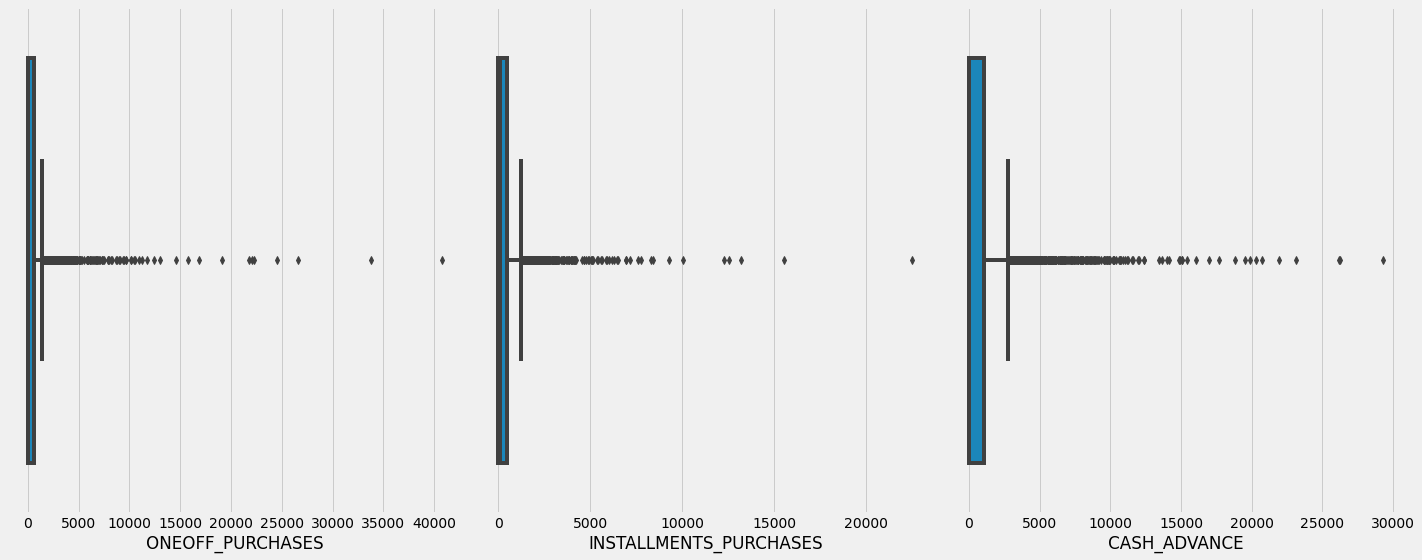

In [80]:
# distribution plots for 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE' 

plt.figure(figsize = (20, 8))
plotnumber = 1

for col in (['ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE']):
    if plotnumber <= 3:
        ax = plt.subplot(1, 3, plotnumber)
        sns.boxplot(X[col])
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

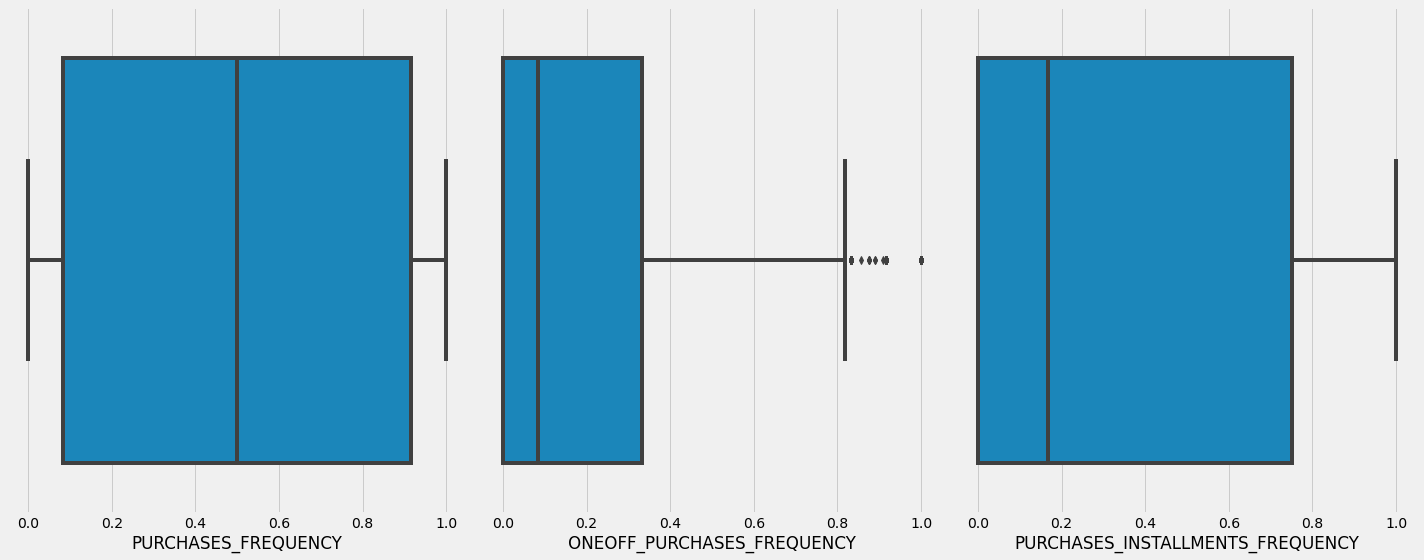

In [81]:
# distribution plots for 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY'

plt.figure(figsize = (20, 8))
plotnumber = 1

for col in (['PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']):
    if plotnumber <= 3:
        ax = plt.subplot(1, 3, plotnumber)
        sns.boxplot(X[col])
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

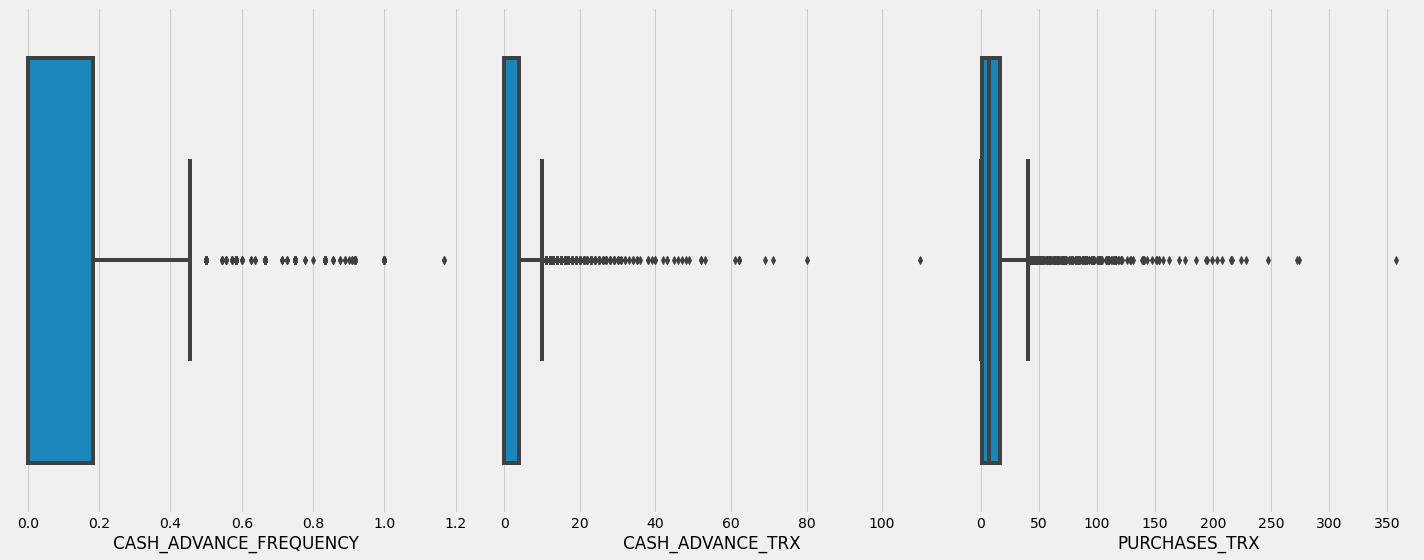

In [82]:
# distribution plots for 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX'

plt.figure(figsize = (20, 8))
plotnumber = 1

for col in (['CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',]):
    if plotnumber <= 3:
        ax = plt.subplot(1, 3, plotnumber)
        sns.boxplot(X[col])
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

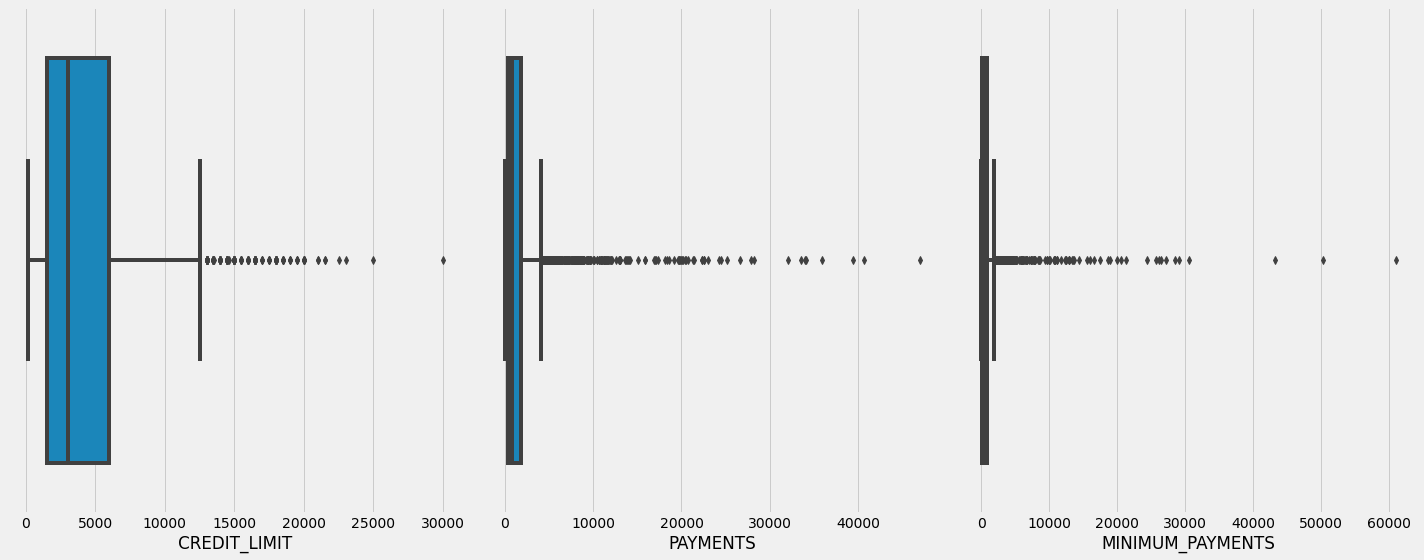

In [83]:
# distribution plots for 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS'

plt.figure(figsize = (20, 8))
plotnumber = 1

for col in (['CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']):
    if plotnumber <= 3:
        ax = plt.subplot(1, 3, plotnumber)
        sns.boxplot(X[col])
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

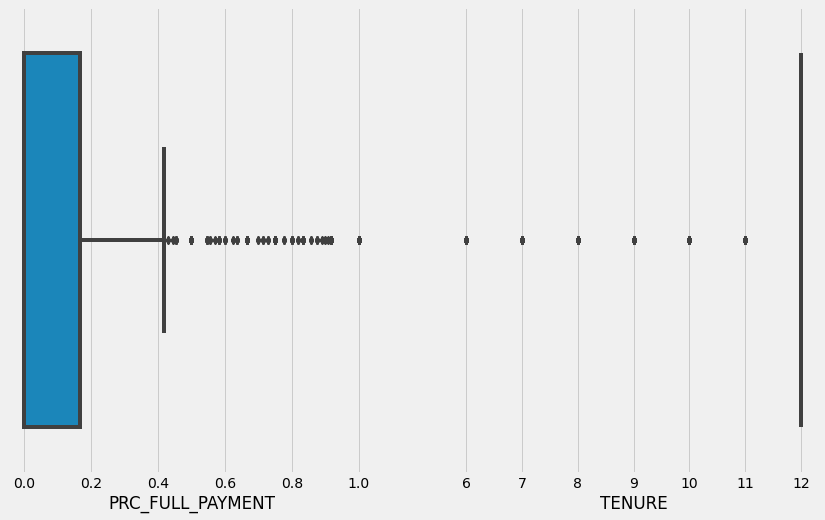

In [84]:
# distribution plots for 'PRC_FULL_PAYMENT', 'TENURE'

plt.figure(figsize = (20, 8))
plotnumber = 1

for col in (['PRC_FULL_PAYMENT', 'TENURE']):
    if plotnumber <= 3:
        ax = plt.subplot(1, 3, plotnumber)
        sns.boxplot(X[col])
        
    plotnumber += 1
    

plt.show()

## **Handling Missing Values**

In [85]:
# Check Missing Values `X`
X.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [86]:
# Impute the missing values with median
X['MINIMUM_PAYMENTS'].fillna(X['MINIMUM_PAYMENTS'].median(), inplace=True)
X['CREDIT_LIMIT'].fillna(X['CREDIT_LIMIT'].median(), inplace=True)

In [87]:
# Check info of `X` after imputation
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4460 non-null   int64  
 1   BALANCE                           4460 non-null   float64
 2   BALANCE_FREQUENCY                 4460 non-null   float64
 3   PURCHASES                         4460 non-null   float64
 4   ONEOFF_PURCHASES                  4460 non-null   float64
 5   INSTALLMENTS_PURCHASES            4460 non-null   float64
 6   CASH_ADVANCE                      4460 non-null   float64
 7   PURCHASES_FREQUENCY               4460 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4460 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4460 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4460 non-null   float64
 11  CASH_ADVANCE_TRX                  4460 non-null   int64  
 12  PURCHA

## **Column Type**

In [88]:
# Get Numerical Columns and Categorical Columns

numerical = X.select_dtypes(include=np.number).columns.tolist()
categorical = X.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns   : ', numerical)
print('Categorical Columns : ', categorical)

Numerical Columns   :  ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
Categorical Columns :  []


In [89]:
# Split Train-Set and Test-Set based on Column Types

X_train_num = X[numerical]
X_test_num = X[numerical]

X_train_num

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,2,4613.570499,1.000000,0.00,0.00,0.00,1728.341939,0.000000,0.000000,0.000000,0.090909,1,0,6000.0,922.218961,1460.635220,0.00,11
1,4,2583.247881,1.000000,1337.35,45.65,1291.70,2484.594650,1.000000,0.083333,1.000000,0.500000,18,21,3000.0,819.792196,6404.855484,0.00,12
2,6,1597.911395,1.000000,0.00,0.00,0.00,162.919727,0.000000,0.000000,0.000000,0.250000,3,0,1800.0,548.420841,416.956325,0.00,12
3,8,3506.489102,1.000000,0.00,0.00,0.00,4467.382055,0.000000,0.000000,0.000000,1.000000,11,0,5000.0,286.708354,628.484562,0.00,6
4,10,2306.310095,1.000000,359.96,0.00,359.96,2843.482435,0.916667,0.000000,0.916667,0.333333,6,11,4000.0,1482.816136,2056.434829,0.00,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4455,8942,83.477053,0.181818,0.00,0.00,0.00,2654.856157,0.000000,0.000000,0.000000,0.083333,2,0,3000.0,12902.188130,1791.729021,0.50,12
4456,8944,8.404256,0.857143,0.00,0.00,0.00,132.266653,0.000000,0.000000,0.000000,0.285714,3,0,2500.0,206.851966,24.421074,0.25,7
4457,8946,4211.539631,1.000000,0.00,0.00,0.00,455.581546,0.000000,0.000000,0.000000,0.083333,1,0,10500.0,1288.287239,1164.178674,0.00,12
4458,8948,111.539712,1.000000,1364.86,0.00,1364.86,0.000000,0.916667,0.000000,0.833333,0.000000,0,11,4000.0,1500.447193,150.868096,0.20,12


In [90]:
# Drop `CUST_ID` because it is presumed to be unrelated
X.drop('CUST_ID', axis=1, inplace=True)
X

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,4613.570499,1.000000,0.00,0.00,0.00,1728.341939,0.000000,0.000000,0.000000,0.090909,1,0,6000.0,922.218961,1460.635220,0.00,11
1,2583.247881,1.000000,1337.35,45.65,1291.70,2484.594650,1.000000,0.083333,1.000000,0.500000,18,21,3000.0,819.792196,6404.855484,0.00,12
2,1597.911395,1.000000,0.00,0.00,0.00,162.919727,0.000000,0.000000,0.000000,0.250000,3,0,1800.0,548.420841,416.956325,0.00,12
3,3506.489102,1.000000,0.00,0.00,0.00,4467.382055,0.000000,0.000000,0.000000,1.000000,11,0,5000.0,286.708354,628.484562,0.00,6
4,2306.310095,1.000000,359.96,0.00,359.96,2843.482435,0.916667,0.000000,0.916667,0.333333,6,11,4000.0,1482.816136,2056.434829,0.00,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4455,83.477053,0.181818,0.00,0.00,0.00,2654.856157,0.000000,0.000000,0.000000,0.083333,2,0,3000.0,12902.188130,1791.729021,0.50,12
4456,8.404256,0.857143,0.00,0.00,0.00,132.266653,0.000000,0.000000,0.000000,0.285714,3,0,2500.0,206.851966,24.421074,0.25,7
4457,4211.539631,1.000000,0.00,0.00,0.00,455.581546,0.000000,0.000000,0.000000,0.083333,1,0,10500.0,1288.287239,1164.178674,0.00,12
4458,111.539712,1.000000,1364.86,0.00,1364.86,0.000000,0.916667,0.000000,0.833333,0.000000,0,11,4000.0,1500.447193,150.868096,0.20,12


## **Feature Scaling**

In [91]:
# Feature Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[2.42269439e-01, 1.00000000e+00, 0.00000000e+00, ...,
        2.39318310e-02, 0.00000000e+00, 8.33333333e-01],
       [1.35652423e-01, 1.00000000e+00, 2.72708346e-02, ...,
        1.04942681e-01, 0.00000000e+00, 1.00000000e+00],
       [8.39100860e-02, 1.00000000e+00, 0.00000000e+00, ...,
        6.83119420e-03, 0.00000000e+00, 1.00000000e+00],
       ...,
       [2.21157853e-01, 1.00000000e+00, 0.00000000e+00, ...,
        1.90744024e-02, 0.00000000e+00, 1.00000000e+00],
       [5.85721265e-03, 1.00000000e+00, 2.78318101e-02, ...,
        2.47134926e-03, 2.00000000e-01, 1.00000000e+00],
       [1.54533360e-02, 1.00000000e+00, 4.05794749e-04, ...,
        2.85983464e-03, 0.00000000e+00, 1.00000000e+00]])

In [92]:
# DataFrame of scaled feature
X_final_df = pd.DataFrame(X_scaled)
X_final_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.242269,1.000000,0.000000,0.000000,0.000000,0.059024,0.000000,0.000000,0.000000,0.077922,0.009091,0.000000,0.195980,0.019651,0.023932,0.00,0.833333
1,0.135652,1.000000,0.027271,0.001120,0.057409,0.084850,1.000000,0.083333,1.000000,0.428571,0.163636,0.058659,0.095477,0.017468,0.104943,0.00,1.000000
2,0.083910,1.000000,0.000000,0.000000,0.000000,0.005564,0.000000,0.000000,0.000000,0.214286,0.027273,0.000000,0.055276,0.011686,0.006831,0.00,1.000000
3,0.184134,1.000000,0.000000,0.000000,0.000000,0.152564,0.000000,0.000000,0.000000,0.857143,0.100000,0.000000,0.162479,0.006109,0.010297,0.00,0.000000
4,0.121110,1.000000,0.007340,0.000000,0.015998,0.097106,0.916667,0.000000,0.916667,0.285714,0.054545,0.030726,0.128978,0.031596,0.033694,0.00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4455,0.004384,0.181818,0.000000,0.000000,0.000000,0.090665,0.000000,0.000000,0.000000,0.071428,0.018182,0.000000,0.095477,0.274921,0.029357,0.50,1.000000
4456,0.000441,0.857143,0.000000,0.000000,0.000000,0.004517,0.000000,0.000000,0.000000,0.244898,0.027273,0.000000,0.078727,0.004408,0.000400,0.25,0.166667
4457,0.221158,1.000000,0.000000,0.000000,0.000000,0.015558,0.000000,0.000000,0.000000,0.071428,0.009091,0.000000,0.346734,0.027451,0.019074,0.00,1.000000
4458,0.005857,1.000000,0.027832,0.000000,0.060660,0.000000,0.916667,0.000000,0.833333,0.000000,0.000000,0.030726,0.128978,0.031972,0.002471,0.20,1.000000


## **Dimensionality Reduction**

In [93]:
# PCA to reduce dimensionality
pca=PCA(n_components=8)
reduced_data=pca.fit_transform(X_scaled)

# **VI. K-Means**

## **With PCA**

In [94]:
# Define Model
k_inertia=[]

for i in range(1, 11):
    km=KMeans(n_clusters=i, n_init=10, init='k-means++')
    km.fit(reduced_data)
    k_inertia.append(km.inertia_)

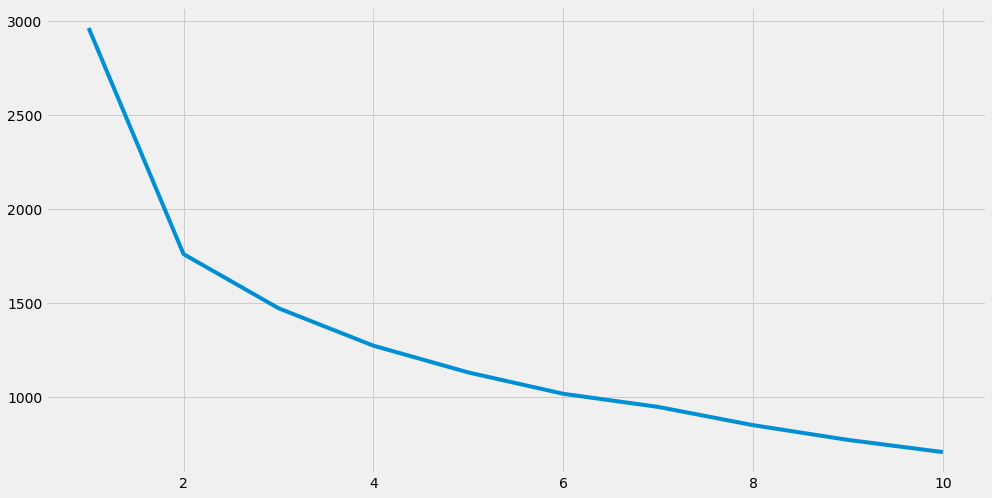

In [95]:
# Plotting the elbow
plt.plot(range(1,11), k_inertia)

Lekukan 'siku' yang berada pada nilai x=2 pada grafik menandakan jumlah cluster sebanyak 2 dianggap sebagai jumlah yang ideal.

In [96]:
# Make cluster
km = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
km.fit(reduced_data)
y_means = km.predict(reduced_data)

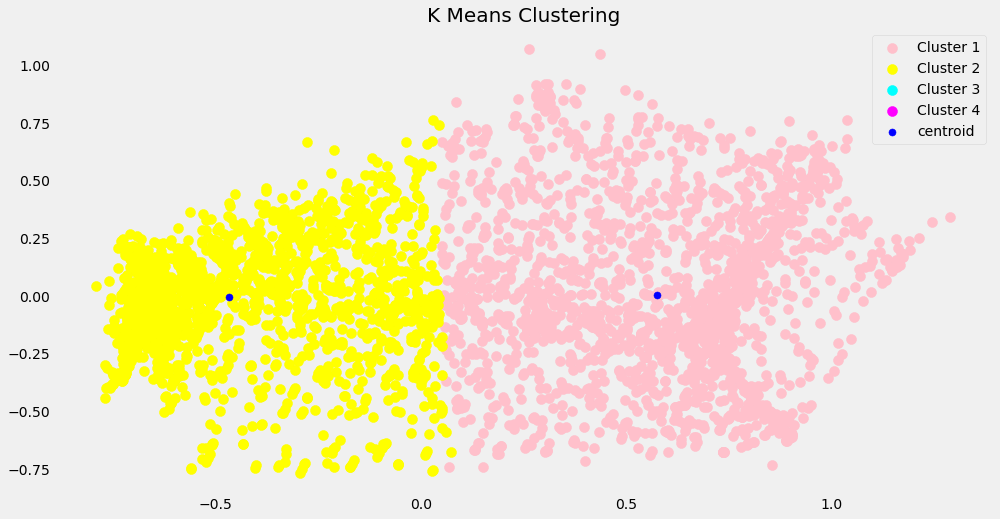

In [97]:
# Plotting clustering result
plt.scatter(reduced_data[y_means == 0, 0], reduced_data[y_means == 0, 1], s = 100, c = 'pink', label = 'Cluster 1')
plt.scatter(reduced_data[y_means == 1, 0], reduced_data[y_means == 1, 1], s = 100, c = 'yellow', label = 'Cluster 2')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centroid')

plt.title('K Means Clustering', fontsize = 20)

plt.legend()
plt.grid()
plt.show()

In [98]:
# Get label array
km.labels_

array([1, 0, 1, ..., 1, 0, 1], dtype=int32)

In [112]:
# Concate clusterred data and dataset
y_means1= pd.DataFrame(y_means)
df_km = pd.concat([data, y_means1], axis=1)
df_km = df_km.rename(columns = {0:"Clusters"})
df_km.head() 

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Clusters
0,2,4613.570499,1.0,0.00,0.00,0.00,1728.341939,0.000000,0.000000,0.000000,0.090909,1,0,6000.0,922.218961,1460.635220,0.0,11,1.0
1,4,2583.247881,1.0,1337.35,45.65,1291.70,2484.594650,1.000000,0.083333,1.000000,0.500000,18,21,3000.0,819.792196,6404.855484,0.0,12,0.0
2,6,1597.911395,1.0,0.00,0.00,0.00,162.919727,0.000000,0.000000,0.000000,0.250000,3,0,1800.0,548.420841,416.956325,0.0,12,1.0
3,8,3506.489102,1.0,0.00,0.00,0.00,4467.382055,0.000000,0.000000,0.000000,1.000000,11,0,5000.0,286.708354,628.484562,0.0,6,1.0
4,10,2306.310095,1.0,359.96,0.00,359.96,2843.482435,0.916667,0.000000,0.916667,0.333333,6,11,4000.0,1482.816136,2056.434829,0.0,12,0.0


In [101]:
# Calculate the score
score = silhouette_score(reduced_data, km.labels_, metric='euclidean')
print('Silhouette score: %.3f' % score)

Silhouette score: 0.383


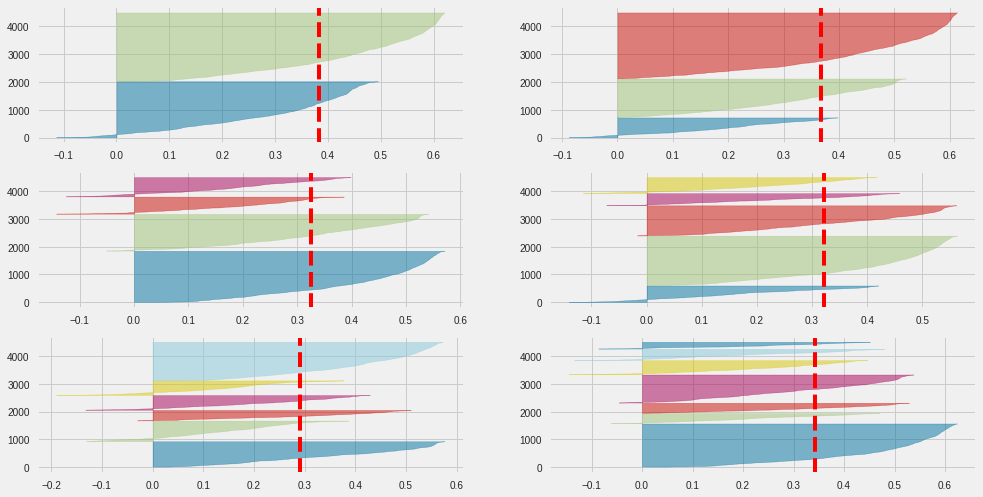

In [166]:
# Visualize Silhouette Score
fig, ax = plt.subplots(3, 2, figsize = (15,8))
for i in np.arange(2,8):
  km = KMeans(n_clusters = i, init="k-means++", n_init = 10, max_iter = 100, random_state = 99)
  q, mod = divmod(i,2)

  visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1][mod])
  visualizer.fit(reduced_data)

Hasil dari silhouette score yang menunjukkan angka 0.38 dapat mengindikasikan model belum dapat cukup baik dalam mengelompokkan segmentasi customer. Perbandingan silhoutte yang ditunjukkan gambar di atas memperlihatkan bahwa customer yang dikelompokkan ke dalam 2 dan 3 cluster memiliki nilai silhoutte yang tertinggi, dengan sebaran data pada 2 cluster lebih besar.

## **Multidimension (Without PCA)**

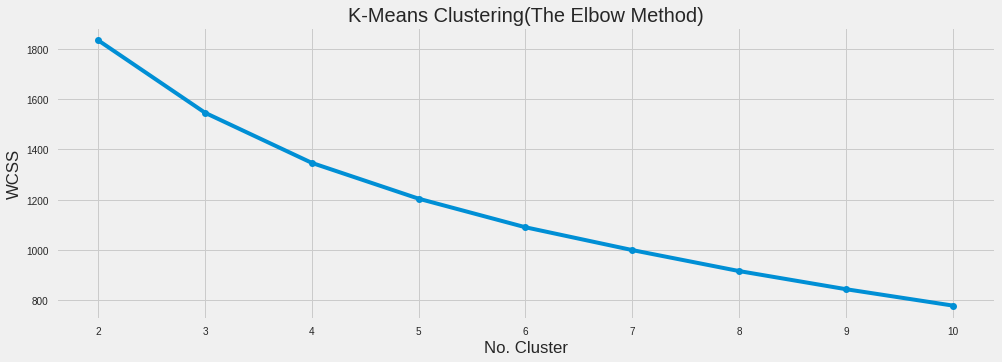

In [114]:
# Elbow Method for `X_scaled` without PCA
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(range(2, 11), wcss, marker ="o")
plt.title('K-Means Clustering(The Elbow Method)', fontsize = 20)
plt.xlabel('No. Cluster')
plt.ylabel('WCSS')
plt.show()

In [118]:
# Make cluster
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
km.fit(X_scaled)
y_kmm = km.predict(X_scaled)

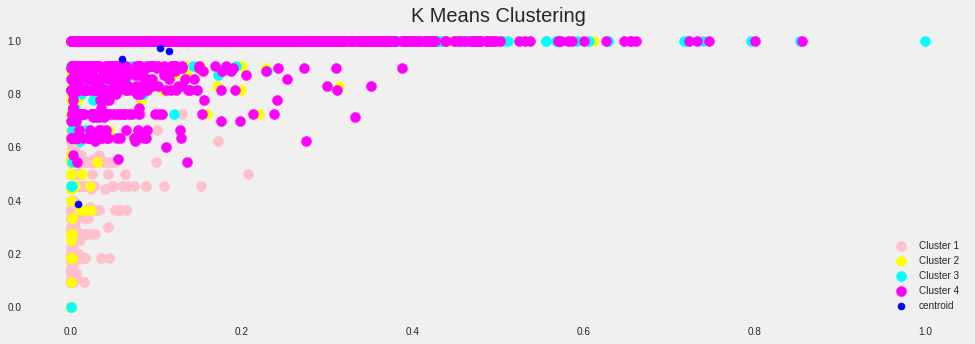

In [117]:
# Plotting clustering result
plt.scatter(X_scaled[y_kmm == 0, 0], X_scaled[y_kmm == 0, 1], s = 100, c = 'pink', label = 'Cluster 1')
plt.scatter(X_scaled[y_kmm == 1, 0], X_scaled[y_kmm == 1, 1], s = 100, c = 'yellow', label = 'Cluster 2')
plt.scatter(X_scaled[y_kmm == 2, 0], X_scaled[y_kmm == 2, 1], s = 100, c = 'cyan', label = 'Cluster 3')
plt.scatter(X_scaled[y_kmm == 3, 0], X_scaled[y_kmm == 3, 1], s = 100, c = 'magenta', label = 'Cluster 4')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centroid')

plt.title('K Means Clustering', fontsize = 20)

plt.legend()
plt.grid()
plt.show()

In [119]:
# Concate clusterred data and dataset
y_y_kmm1= pd.DataFrame(y_kmm)
df_kmm = pd.concat([data, y_means1], axis=1)
df_kmm = df_kmm.rename(columns = {0:"Clusters"})
df_kmm.head() 

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Clusters
0,2,4613.570499,1.0,0.00,0.00,0.00,1728.341939,0.000000,0.000000,0.000000,0.090909,1,0,6000.0,922.218961,1460.635220,0.0,11,1.0
1,4,2583.247881,1.0,1337.35,45.65,1291.70,2484.594650,1.000000,0.083333,1.000000,0.500000,18,21,3000.0,819.792196,6404.855484,0.0,12,0.0
2,6,1597.911395,1.0,0.00,0.00,0.00,162.919727,0.000000,0.000000,0.000000,0.250000,3,0,1800.0,548.420841,416.956325,0.0,12,1.0
3,8,3506.489102,1.0,0.00,0.00,0.00,4467.382055,0.000000,0.000000,0.000000,1.000000,11,0,5000.0,286.708354,628.484562,0.0,6,1.0
4,10,2306.310095,1.0,359.96,0.00,359.96,2843.482435,0.916667,0.000000,0.916667,0.333333,6,11,4000.0,1482.816136,2056.434829,0.0,12,0.0


In [120]:
# Calculate the score
score = silhouette_score(X_scaled, km.labels_, metric='euclidean')
print('Silhouette score: %.3f' % score)

Silhouette score: 0.315


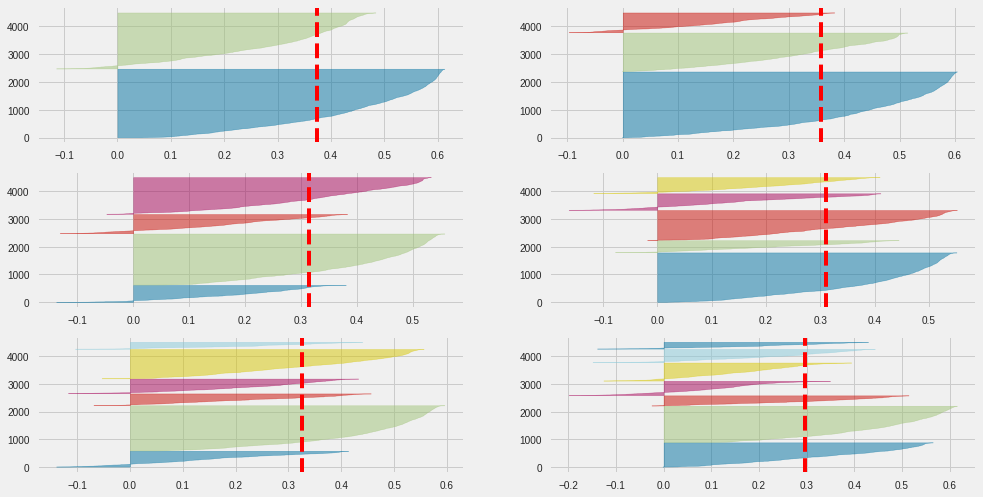

In [165]:
# Visualize Silhouette Score
fig, ax = plt.subplots(3, 2, figsize = (15,8))
for i in np.arange(2,8):
  km = KMeans(n_clusters = i, init="k-means++", n_init = 10, max_iter = 100, random_state = 2)
  q, mod = divmod(i,2)

  visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1][mod])
  visualizer.fit(X_scaled)

# **VII. Agglomerative Clustering**

In [109]:
#Define and Train the Model
agg_clust = AgglomerativeClustering(n_clusters=4)
assigned_clusters = agg_clust.fit_predict(reduced_data)

In [113]:
# Concate clusterred data and dataset
assigned_clusters1= pd.DataFrame(assigned_clusters)
df_agg = pd.concat([data, assigned_clusters1], axis=1)
df_agg = df_agg.rename(columns = {0:"Clusters"})
df_agg.head() 

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Clusters
0,2,4613.570499,1.0,0.00,0.00,0.00,1728.341939,0.000000,0.000000,0.000000,0.090909,1,0,6000.0,922.218961,1460.635220,0.0,11,0.0
1,4,2583.247881,1.0,1337.35,45.65,1291.70,2484.594650,1.000000,0.083333,1.000000,0.500000,18,21,3000.0,819.792196,6404.855484,0.0,12,1.0
2,6,1597.911395,1.0,0.00,0.00,0.00,162.919727,0.000000,0.000000,0.000000,0.250000,3,0,1800.0,548.420841,416.956325,0.0,12,0.0
3,8,3506.489102,1.0,0.00,0.00,0.00,4467.382055,0.000000,0.000000,0.000000,1.000000,11,0,5000.0,286.708354,628.484562,0.0,6,0.0
4,10,2306.310095,1.0,359.96,0.00,359.96,2843.482435,0.916667,0.000000,0.916667,0.333333,6,11,4000.0,1482.816136,2056.434829,0.0,12,1.0


In [122]:
# Calculate the score
score = silhouette_score(reduced_data, agg_clust.labels_, metric='euclidean')
print('Silhouette score: %.3f' % score)

Silhouette score: 0.309


# **VIII. Gaussian Mixture**

In [159]:
# Predict using Gaussian Mixture
gm = GaussianMixture(n_components=3, n_init=10, random_state=15)
gm.fit(reduced_data)

GaussianMixture(n_components=3, n_init=10, random_state=15)

In [160]:
# Predict as `Hard Clustering`
gm.predict(reduced_data)

array([1, 0, 1, ..., 1, 0, 1])

In [161]:
# Predict as `Soft Clustering`
gm.predict_proba(reduced_data)

array([[0.00000000e+00, 9.99999830e-01, 1.70269652e-07],
       [9.99993711e-01, 0.00000000e+00, 6.28926533e-06],
       [1.25830178e-03, 9.98741662e-01, 3.64059821e-08],
       ...,
       [1.36564184e-02, 9.86343372e-01, 2.09233517e-07],
       [9.99930444e-01, 0.00000000e+00, 6.95561767e-05],
       [3.49825647e-03, 9.96501652e-01, 9.12213252e-08]])

# **IX. Model Inference**

In [174]:
# Save the Files

import joblib
import json

with open('model_pca.pkl', 'wb') as file_1:
  joblib.dump(pca, file_1)

with open('model_kmeans.pkl', 'wb') as file_2:
  joblib.dump(km, file_2)

with open('model_agglo.pkl', 'wb') as file_3:
  joblib.dump(agg_clust, file_3)

with open('model_gaussian.pkl', 'wb') as file_4:
  joblib.dump(gm, file_4)

with open('model_scaler.pkl', 'wb') as file_5:
  joblib.dump(scaler, file_5)

with open('list_num_cols.txt', 'w') as file_6:
  json.dump(numerical, file_6)

with open('list_cat_cols.txt', 'w') as file_7:
  json.dump(categorical, file_7)

In [175]:
# Load All Files

import joblib
import json

with open('model_pca.pkl', 'rb') as file_1:
  pca = joblib.load(file_1)

with open('model_kmeans.pkl', 'rb') as file_2:
  km = joblib.load(file_2)

with open('model_agglo.pkl', 'rb') as file_3:
  agg_clust = joblib.load(file_3)

with open('model_gaussian.pkl', 'rb') as file_4:
  gm = joblib.load(file_4)

with open('model_scaler.pkl', 'rb') as file_5:
  scaler = joblib.load(file_5)

with open('list_num_cols.txt', 'r') as file_6:
  numerical = json.load(file_6)

with open('list_cat_cols.txt', 'r') as file_7:
  categorical = json.load(file_7)

In [176]:
# Split between Numerical Columns and Categorical Columns

data_inf_num = data_inference[numerical]
data_inf_cat = data_inference[categorical]

data_inf_num.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,6190,82.784219,0.363636,431.28,431.28,0.00,0.000000,0.083333,0.083333,0.00,0.000000,0,1,3000.0,734.818798,173.255235,0.000000,12
1,126,4228.417754,1.000000,11994.71,11994.71,0.00,496.521561,0.250000,0.250000,0.00,0.083333,2,8,13450.0,508.797444,1725.645623,0.000000,12
2,676,285.645503,1.000000,1265.24,893.54,371.70,0.000000,0.833333,0.500000,0.50,0.000000,0,24,7000.0,1791.285108,197.065604,0.083333,12
3,6084,1121.068043,1.000000,0.00,0.00,0.00,56.461201,0.000000,0.000000,0.00,0.166667,3,0,1200.0,236.092440,351.184105,0.000000,12
4,1898,238.184435,0.750000,2068.15,0.00,2068.15,0.000000,0.875000,0.000000,0.75,0.000000,0,7,4000.0,2143.223171,117.977018,0.833333,8


In [177]:
data_inf_num.drop('CUST_ID', axis=1, inplace=True)
data_inf_num.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,82.784219,0.363636,431.28,431.28,0.00,0.000000,0.083333,0.083333,0.00,0.000000,0,1,3000.0,734.818798,173.255235,0.000000,12
1,4228.417754,1.000000,11994.71,11994.71,0.00,496.521561,0.250000,0.250000,0.00,0.083333,2,8,13450.0,508.797444,1725.645623,0.000000,12
2,285.645503,1.000000,1265.24,893.54,371.70,0.000000,0.833333,0.500000,0.50,0.000000,0,24,7000.0,1791.285108,197.065604,0.083333,12
3,1121.068043,1.000000,0.00,0.00,0.00,56.461201,0.000000,0.000000,0.00,0.166667,3,0,1200.0,236.092440,351.184105,0.000000,12
4,238.184435,0.750000,2068.15,0.00,2068.15,0.000000,0.875000,0.000000,0.75,0.000000,0,7,4000.0,2143.223171,117.977018,0.833333,8


In [ ]:
# Feature Scaling and Feature Encoding

data_inf_num_scaled = scaler.transform(data_inf_num)
data_inf_num_scaled

In [ ]:
# Dimensionality Reduction
data_inf_pca = pca.transform(data_inf_num_scaled)
data_inf_pca

**K-Means With PCA**

In [180]:
# Predict using K-Means

inf_pred_km = km.predict(data_inf_pca)
inf_pred_km

array([4, 0, 5, 0, 2, 1, 0, 1, 0, 0, 3, 4, 1, 1, 3], dtype=int32)

In [181]:
# Create DataFrame

inf_pred_km_df = pd.DataFrame(inf_pred_km, columns=['Clusters'])
inf_pred_km_df.head()

,Clusters
0,4
1,0
2,5
3,0
4,2


In [182]:
# Concate between Inference-Set and Rating's Prediction

fin_km = pd.concat([data_inference, inf_pred_km_df], axis=1)
fin_km.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Clusters
0,6190,82.784219,0.363636,431.28,431.28,0.00,0.000000,0.083333,0.083333,0.00,0.000000,0,1,3000.0,734.818798,173.255235,0.000000,12,4
1,126,4228.417754,1.000000,11994.71,11994.71,0.00,496.521561,0.250000,0.250000,0.00,0.083333,2,8,13450.0,508.797444,1725.645623,0.000000,12,0
2,676,285.645503,1.000000,1265.24,893.54,371.70,0.000000,0.833333,0.500000,0.50,0.000000,0,24,7000.0,1791.285108,197.065604,0.083333,12,5
3,6084,1121.068043,1.000000,0.00,0.00,0.00,56.461201,0.000000,0.000000,0.00,0.166667,3,0,1200.0,236.092440,351.184105,0.000000,12,0
4,1898,238.184435,0.750000,2068.15,0.00,2068.15,0.000000,0.875000,0.000000,0.75,0.000000,0,7,4000.0,2143.223171,117.977018,0.833333,8,2


**Agglomerative Clustering**

In [184]:
# Predict using Agglomerative Clustering (using '.fit_predict' because it doesn't have '.predict')

inf_pred_agg = agg_clust.fit_predict(data_inf_pca)
inf_pred_agg

array([3, 1, 2, 1, 0, 2, 1, 2, 1, 1, 0, 3, 2, 2, 0])

In [185]:
# Create DataFrame

inf_pred_agg_df = pd.DataFrame(inf_pred_agg, columns=['Clusters'])
inf_pred_agg_df.head()

,Clusters
0,3
1,1
2,2
3,1
4,0


In [186]:
# Concate between Inference-Set and Rating's Prediction

fin_agg = pd.concat([data_inference, inf_pred_agg_df], axis=1)
fin_agg.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Clusters
0,6190,82.784219,0.363636,431.28,431.28,0.00,0.000000,0.083333,0.083333,0.00,0.000000,0,1,3000.0,734.818798,173.255235,0.000000,12,3
1,126,4228.417754,1.000000,11994.71,11994.71,0.00,496.521561,0.250000,0.250000,0.00,0.083333,2,8,13450.0,508.797444,1725.645623,0.000000,12,1
2,676,285.645503,1.000000,1265.24,893.54,371.70,0.000000,0.833333,0.500000,0.50,0.000000,0,24,7000.0,1791.285108,197.065604,0.083333,12,2
3,6084,1121.068043,1.000000,0.00,0.00,0.00,56.461201,0.000000,0.000000,0.00,0.166667,3,0,1200.0,236.092440,351.184105,0.000000,12,1
4,1898,238.184435,0.750000,2068.15,0.00,2068.15,0.000000,0.875000,0.000000,0.75,0.000000,0,7,4000.0,2143.223171,117.977018,0.833333,8,0


**Gaussian Mixture**

In [187]:
# Predict using Gaussian Mixture

inf_pred_gm = gm.predict(data_inf_pca)
inf_pred_gm

array([1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0])

In [188]:
# Create DataFrame

inf_pred_gm_df = pd.DataFrame(inf_pred_gm, columns=['Clusters'])
inf_pred_gm_df.head()

,Clusters
0,1
1,0
2,0
3,1
4,2


In [ ]:
# Concate between Inference-Set and Rating's Prediction

fin_gm = pd.concat([data_inference, inf_pred_gm_df], axis=1)
fin_gm.head()

# **X. Conclusion**

Dalam melakukan pengelompokkan customer segmentation menggunakan tiga algoritma berbeda, clustering dengan metode PCA dan Agglomerative Clustering menghasilkan dua cluster customer sementara Gaussian Mixture menghasilkan tiga cluster customer.

Algoritma seperti K-Means akan mengalami penurunan skalabilitas jika jumlah dimensi meningkat atau cukup banyak. Jumlah dimensi yang sudah dikurangi menggunakan metode PCA tidak cukup dalam meningkatkan nilai silhoutte yang digunakan sebagai metrics akurasi. Feature selection yang lebih mendalam dan berbasis korelasi kemungkinan akan dapat meningkatkan evaluasi model daripada hanya mengandalkan PCA.

# **Pertanyaan**

Jawab pertanyaan berikut:

1. Apakah yang dimaksud dengan inertia pada algoritma K-Means ?
<br>**Jawab:** Inertia adalah jarak antar titik-titik dalam sebuah cluster dari centroid.

2. Jelaskan yang dimaksud dengan Elbow Method (alasan penggunaan, cara penggunaan, kelemahan/kelebihan, dll) !
<br>**Jawab:** *Elbow Method* adalah salah satu metode yang dapat digunakan untuk memilih nilai K yang tepat dalam metode clustering K-Means. Nilai K sendiri digunakan untuk menentukan jumlah cluster yang tepat. Cara kerjanya adalah menggunakan visualisasi dalam bentuk grafik, di mana nilai X pada grafik menunjukkan jumlah cluster dan nilai Y pada grafik menunjuukan nilai inertia. Jumlah cluster di mana penurunan nilai inersia ini menjadi konstan dapat dipilih sebagai jumlah cluster yang tepat. Kelebihan metode ini adalah cukup cepat dan praktis untuk diterapkan. Kekurangannya adalah jika sebenarnya terdapat dua cluster namun jaraknya berdekatan, maka akan dianggap hanya terdapat satu cluster saja karena metode ini menggunakan dasar jarak terdekat dari centroid sebagai acuannya.


3. Jelaskan perbedaan masing-masing algoritma clustering yang anda gunakan dalam kasus ini !
<br>**Jawab:** Terdapat 3 jenis algoritma clustering yang digunakan yaitu K-Means, Agglomerative Clustering, dan Gaussian Mixture. K-Means merupakan clustering berdasarkan jarak terdekat dari titik pusat (centroid) data. Gaussian Mixture merupakan clustering berbasis distribusi dan berkaitan dengan standar deviasi (distribusi gaussian). Agglomerative Clustering merupakan pendekatan 'Bottom-Up' yang dalam implementasinya pada awalnya sebuah data merupakan cluster tunggal lalu kemudian secara berurutan menggabungkan pasangan klaster berdasarkan jarak yang paling sedikit (kesamaan paling banyak).